## Loading in and checking the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPool2D
from keras.optimizers import adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using plaidml.keras.backend backend.


In [2]:
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")

## Splitting the data and its label

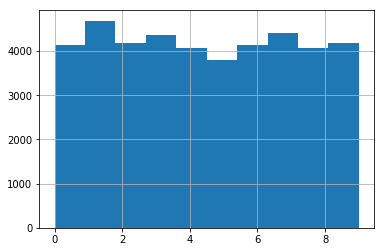

In [3]:
train_label = train_data['label']
train_data = train_data.drop('label', axis=1)
train_label.hist()

In [4]:
train_data = train_data / 255.0
test_data = test_data / 255.0

In [ ]:
train_data = train_data.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)

In [ ]:
train_label = to_categorical(train_label, num_classes=10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2, stratify=train_label)

## Checking the image quality of a random value

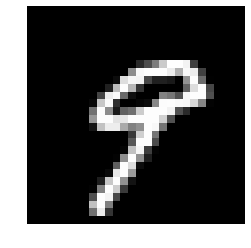

In [ ]:
some_digit = X_train[2000]
some_digit_image = some_digit[:,:,0]

plt.imshow(some_digit_image, interpolation='nearest', cmap='gray')

plt.axis('off')
plt.show()


## Create Swish Activation Function

swish(x) = x * sigmoid(beta * x)

In [ ]:
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})

# Attempting to solve using a CNN

In [ ]:
model = Sequential()

get_custom_objects().update({'swish': Activation(swish )})

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(256, activation = "swish"))
model.add(Dense(100, activation = "swish"))
model.add(BatchNormalization())

model.add(Dense(10, activation = "softmax"))

# Define the optimizer

optimizer = adam(lr=0.001,  epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

INFO:plaidml:Opening device "metal_amd_radeon_vega_frontier_edition.0"


In [ ]:
from keras.callbacks import EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

epochs = 200
batch_size = 64 #7680 # Warning size choosen based on a GPU with 16GB of memory and utalizes ~95%.

## Generating more data!

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
datagen.fit(X_train)

In [ ]:
import scipy.ndimage
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/200


INFO:plaidml:Analyzing Ops: 174 of 473 operations complete


 - 26s - loss: 0.1884 - acc: 0.9404 - val_loss: 0.0952 - val_acc: 0.9713
Epoch 2/200
 - 15s - loss: 0.0758 - acc: 0.9767 - val_loss: 0.0495 - val_acc: 0.9844
Epoch 3/200
 - 16s - loss: 0.0561 - acc: 0.9821 - val_loss: 0.0599 - val_acc: 0.9826
Epoch 4/200
 - 15s - loss: 0.0493 - acc: 0.9848 - val_loss: 0.0398 - val_acc: 0.9873
Epoch 5/200
 - 16s - loss: 0.0414 - acc: 0.9866 - val_loss: 0.0427 - val_acc: 0.9869
Epoch 6/200
 - 15s - loss: 0.0379 - acc: 0.9876 - val_loss: 0.0444 - val_acc: 0.9852
Epoch 7/200
 - 15s - loss: 0.0321 - acc: 0.9899 - val_loss: 0.0378 - val_acc: 0.9890
Epoch 8/200
 - 15s - loss: 0.0321 - acc: 0.9899 - val_loss: 0.0325 - val_acc: 0.9902
Epoch 9/200
 - 15s - loss: 0.0302 - acc: 0.9907 - val_loss: 0.0312 - val_acc: 0.9912
Epoch 10/200
 - 15s - loss: 0.0273 - acc: 0.9913 - val_loss: 0.0340 - val_acc: 0.9899
Epoch 11/200
 - 15s - loss: 0.0249 - acc: 0.9923 - val_loss: 0.0238 - val_acc: 0.9929
Epoch 12/200
 - 15s - loss: 0.0237 - acc: 0.9926 - val_loss: 0.0376 - val_a

## Building our results

In [ ]:
results = model.predict(test_data)

In [ ]:
results = np.argmax(results,axis = 1)

In [ ]:
# Preview predictions
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(test_data[i][:,:,0], cmap='gray')
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [ ]:
# Exporting our results for Kaggle
df = pd.DataFrame(results)
df.index.name='ImageId'
df.index+=1
df.columns=['Label']
df.to_csv('./datasets/results.csv', header=True)

In [ ]:
import coremltools